In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import nltk
from nltk.corpus import stopwords
import string

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB , BernoulliNB
from sklearn import svm

In [4]:
stop = set(stopwords.words('english'))
punctuations = string.punctuation

def preprocess(text):
    # Lowercase
    text = text.lower()
    # Remove punctuation
    text = ''.join([char for char in text if char not in punctuations])
    # Remove stopwords
    text = ' '.join([word for word in text.split() if word not in stop])
    return text

In [10]:
developed = pd.read_csv("./modeldeveloped.csv")
developing = pd.read_csv("./modeldeveloping.csv")
under = pd.read_csv("./under.csv")

In [12]:
filtered_developed = developed[developed['score'] <= 200]

In [15]:
filtered_developed['score'] = filtered_developed['score']/max(filtered_developed['score'])

In [17]:
filtered_developed['corpus'] = filtered_developed['Title'] + filtered_developed['Content']

In [19]:
filtered_developed['score'] = filtered_developed['score'].round(2)

In [22]:
labels = []
for i in filtered_developed.index:
    if filtered_developed['score'][i] < 0.33:
        labels.append("low-relevance")
    if 0.33 <= filtered_developed['score'][i] <= 0.66:
        labels.append("medium-relevance")
    if 0.67 <= filtered_developed['score'][i] <= 1.0:
        labels.append("high-relevance")
filtered_developed['label'] = labels

In [24]:
filtered_developed = filtered_developed[['corpus','label']]

In [26]:
filtered_developed.to_csv("developed-ready.csv")

In [34]:
def labeling(df,column):
    df[column] = df[column]/max(df[column])
    df['corpus'] = df['Title'] + df['Content']
    df[column] = df[column].round(2)
    labels = []
    for i in df.index:
        if df[column][i] < 0.33:
            labels.append("low-relevance")
        if 0.33 <= df[column][i] <= 0.66:
            labels.append("medium-relevance")
        if 0.67 <= df[column][i] <= 1.0:
            labels.append("high-relevance")
    df['labels'] = labels
    return df[['corpus','labels']]

In [35]:
filtered_developing = labeling(developing , 'score')

In [37]:
filtered_under = labeling(under, 'score')

In [39]:
filtered_developing.to_csv("developing-ready.csv")
filtered_under.to_csv("under-ready.csv")

In [43]:
def maker(df , text ,target):
    le = LabelEncoder()
    y = le.fit_transform(df[target])
    df['clean_paragraph'] = df[text].apply(preprocess)
    vectorizer = TfidfVectorizer(max_features=5000) 
    X = vectorizer.fit_transform(df['clean_paragraph']).toarray()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    gnb = GaussianNB()
    rfc = RandomForestClassifier()
    lr = LogisticRegression()
    bb = BernoulliNB()
    sv = svm.SVC(decision_function_shape='ovo')
    gnb.fit(X_train , y_train)
    rfc.fit(X_train , y_train)
    lr.fit(X_train , y_train)
    bb.fit(X_train , y_train)
    sv.fit(X_train , y_train)
    y_pred1 = gnb.predict(X_test)
    y_pred2 = rfc.predict(X_test)
    y_pred3 = lr.predict(X_test)
    y_pred4 = bb.predict(X_test)
    y_pred5 = sv.predict(X_test)
    acc1 = accuracy_score(y_test, y_pred1)
    acc2 = accuracy_score(y_test, y_pred2)
    acc3 = accuracy_score(y_test, y_pred3)
    acc4 = accuracy_score(y_test, y_pred4)
    acc5 = accuracy_score(y_test, y_pred5)
    y_test_labels = le.inverse_transform((y_test))
    y_pred_labels = le.inverse_transform(y_pred1)
    crgnb = classification_report(y_test_labels, y_pred_labels,output_dict=True)
    cmgnb = confusion_matrix(y_test_labels, y_pred_labels)
    y_pred_labels2 = le.inverse_transform(y_pred2)
    crrfc = classification_report(y_test_labels, y_pred_labels2,output_dict=True)
    cmrfc = confusion_matrix(y_test_labels, y_pred_labels2)
    y_pred_labels3 = le.inverse_transform(y_pred3)
    crlr = classification_report(y_test_labels, y_pred_labels3,output_dict=True)
    cmlr = confusion_matrix(y_test_labels, y_pred_labels3)
    y_pred_labels4 = le.inverse_transform(y_pred4)
    crbb = classification_report(y_test_labels, y_pred_labels4,output_dict=True)
    cmbb = confusion_matrix(y_test_labels, y_pred_labels)
    y_pred_labels5 = le.inverse_transform(y_pred5)
    crsv = classification_report(y_test_labels, y_pred_labels5,output_dict=True)
    cmsv = confusion_matrix(y_test_labels, y_pred_labels)
    models = {
        "Gaussian NB":[acc1 ,crgnb,cmgnb],
        "Random Forest Classifier":[acc2 ,crrfc,cmrfc],
        "Logistic Regression":[acc1 ,crlr,cmlr],
        "Bernoulli NB":[acc1 ,crbb,cmbb],
        "SVM":[acc1 ,crsv,cmsv]
    }
    return models

In [44]:
developed = maker(filtered_developed , 'corpus' , 'label')
developing = maker(filtered_developing , 'corpus' , 'labels')
under = maker(filtered_under , 'corpus' , 'labels')

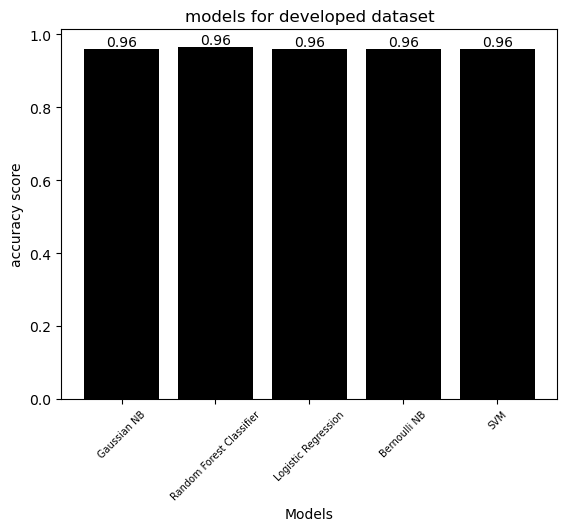

In [51]:
k = developed.keys()
acc = [developed[keys][0] for keys in k]
plt.bar(developed.keys() , acc , color='black')
plt.xticks(rotation = 45 , size = 7)
plt.xlabel("Models")
plt.ylabel("accuracy score")
plt.title("models for developed dataset")
for i, value in enumerate(acc):
    plt.text(i, value, str(round(value,2)), ha='center', va='bottom')

In [56]:
cms = [developed[keys][2] for keys in k]

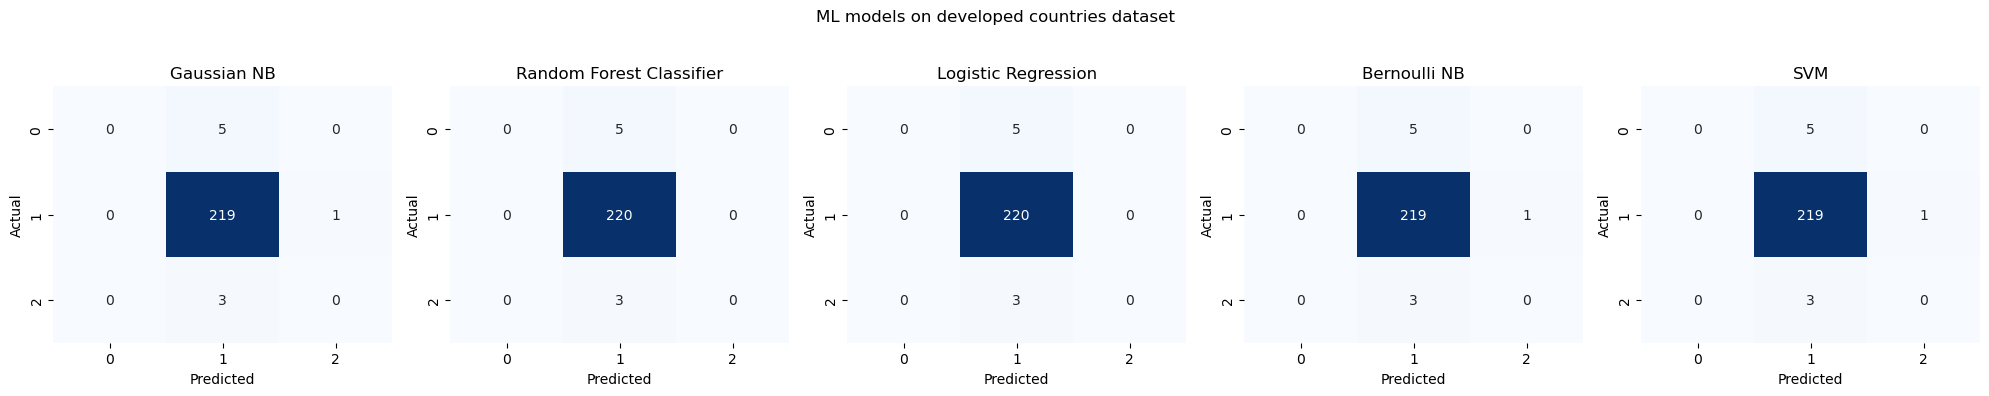

In [63]:
import seaborn as sns
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
fig.suptitle('ML models on developed countries dataset')

# Plot each confusion matrix
for i, (cm, ax) in enumerate(zip(cms, axes)):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)
    ax.set_title(list(developed.keys())[i])
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [64]:
crs = [developed[keys][1] for keys in k]

In [66]:
models = ["Gaussian NB","Random Forest Classifier","Logistic Regression","Bernoulli NB","SVC"]

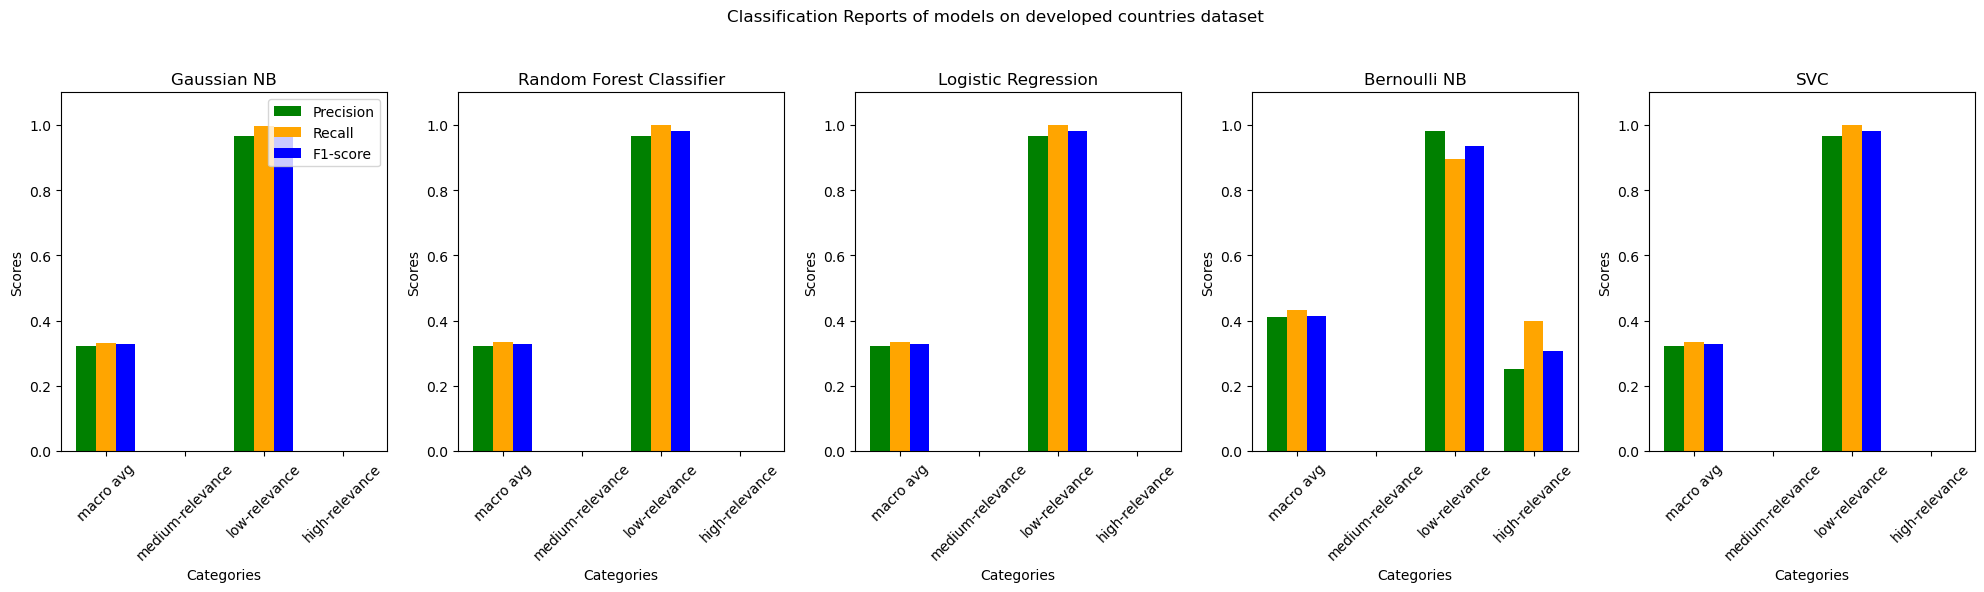

In [74]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report

categories = ['macro avg', 'medium-relevance','low-relevance','high-relevance']
bar_width = 0.25

# Create subplots
fig, axes = plt.subplots(1, 5, figsize=(20, 6))
fig.suptitle('Classification Reports of models on developed countries dataset')
# Plot each classification report
for i, (cr, ax) in enumerate(zip(crs, axes)):
    x = np.arange(len(categories))
    
    # Extracting precision, recall, and f1-score
    precision = [cr[cat]['precision'] for cat in categories]
    recall = [cr[cat]['recall'] for cat in categories]
    f1_score = [cr[cat]['f1-score'] for cat in categories]
    
    # Plot bars
    ax.bar(x - bar_width, precision, width=bar_width, color='green', label='Precision')
    ax.bar(x, recall, width=bar_width, color='orange', label='Recall')
    ax.bar(x + bar_width, f1_score, width=bar_width, color='blue', label='F1-score')
    
    # Formatting
    ax.set_title(models[i])
    ax.set_xticks(x)
    ax.set_xticklabels(categories, rotation=45)
    ax.set_ylim(0, 1.1)  # Ensure the y-axis is consistent
    ax.set_xlabel('Categories')
    ax.set_ylabel('Scores')
    if i == 0:  # Add legend only for the first subplot
        ax.legend(loc='upper right')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

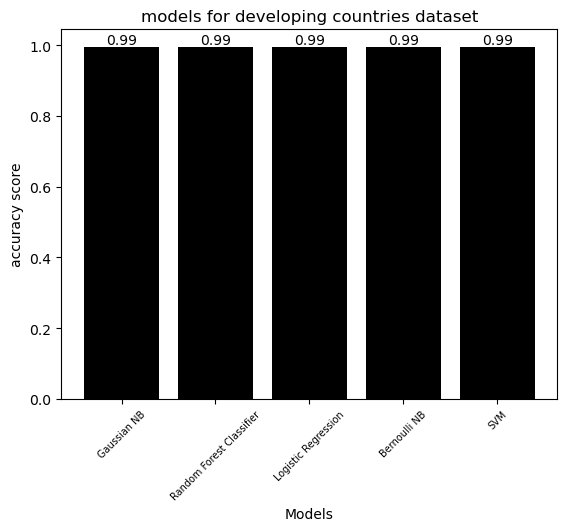

In [75]:
k = developing.keys()
acc = [developing[keys][0] for keys in k]
plt.bar(developing.keys() , acc , color='black')
plt.xticks(rotation = 45 , size = 7)
plt.xlabel("Models")
plt.ylabel("accuracy score")
plt.title("models for developing countries dataset")
for i, value in enumerate(acc):
    plt.text(i, value, str(round(value,2)), ha='center', va='bottom')

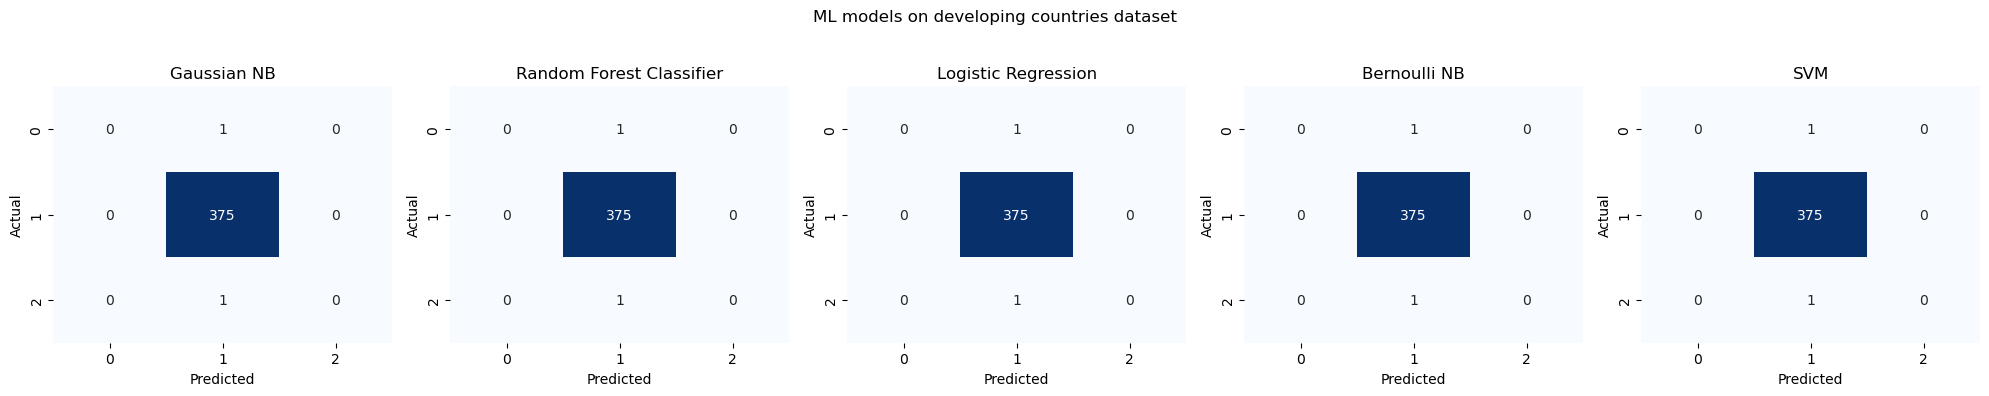

In [76]:
cms = [developing[keys][2] for keys in k]
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
fig.suptitle('ML models on developing countries dataset')

# Plot each confusion matrix
for i, (cm, ax) in enumerate(zip(cms, axes)):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)
    ax.set_title(list(developed.keys())[i])
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

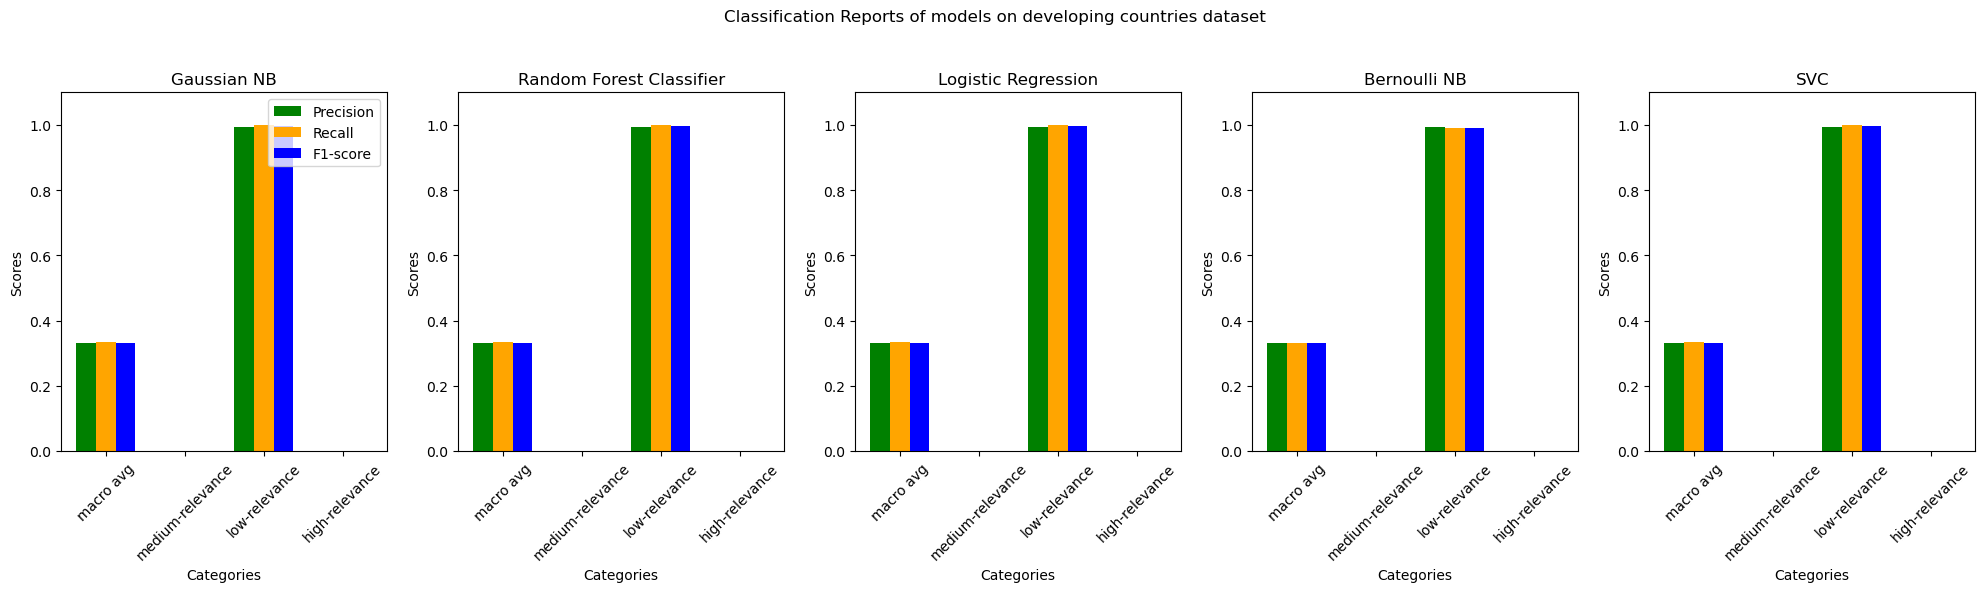

In [78]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report

categories = ['macro avg', 'medium-relevance','low-relevance','high-relevance']
bar_width = 0.25
crs = [developing[keys][1] for keys in k]
# Create subplots
fig, axes = plt.subplots(1, 5, figsize=(20, 6))
fig.suptitle('Classification Reports of models on developing countries dataset')
# Plot each classification report
for i, (cr, ax) in enumerate(zip(crs, axes)):
    x = np.arange(len(categories))
    
    # Extracting precision, recall, and f1-score
    precision = [cr[cat]['precision'] for cat in categories]
    recall = [cr[cat]['recall'] for cat in categories]
    f1_score = [cr[cat]['f1-score'] for cat in categories]
    
    # Plot bars
    ax.bar(x - bar_width, precision, width=bar_width, color='green', label='Precision')
    ax.bar(x, recall, width=bar_width, color='orange', label='Recall')
    ax.bar(x + bar_width, f1_score, width=bar_width, color='blue', label='F1-score')
    
    # Formatting
    ax.set_title(models[i])
    ax.set_xticks(x)
    ax.set_xticklabels(categories, rotation=45)
    ax.set_ylim(0, 1.1)  # Ensure the y-axis is consistent
    ax.set_xlabel('Categories')
    ax.set_ylabel('Scores')
    if i == 0:  # Add legend only for the first subplot
        ax.legend(loc='upper right')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

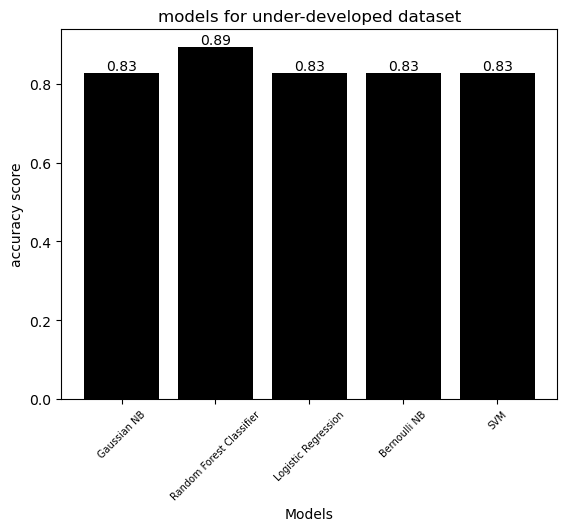

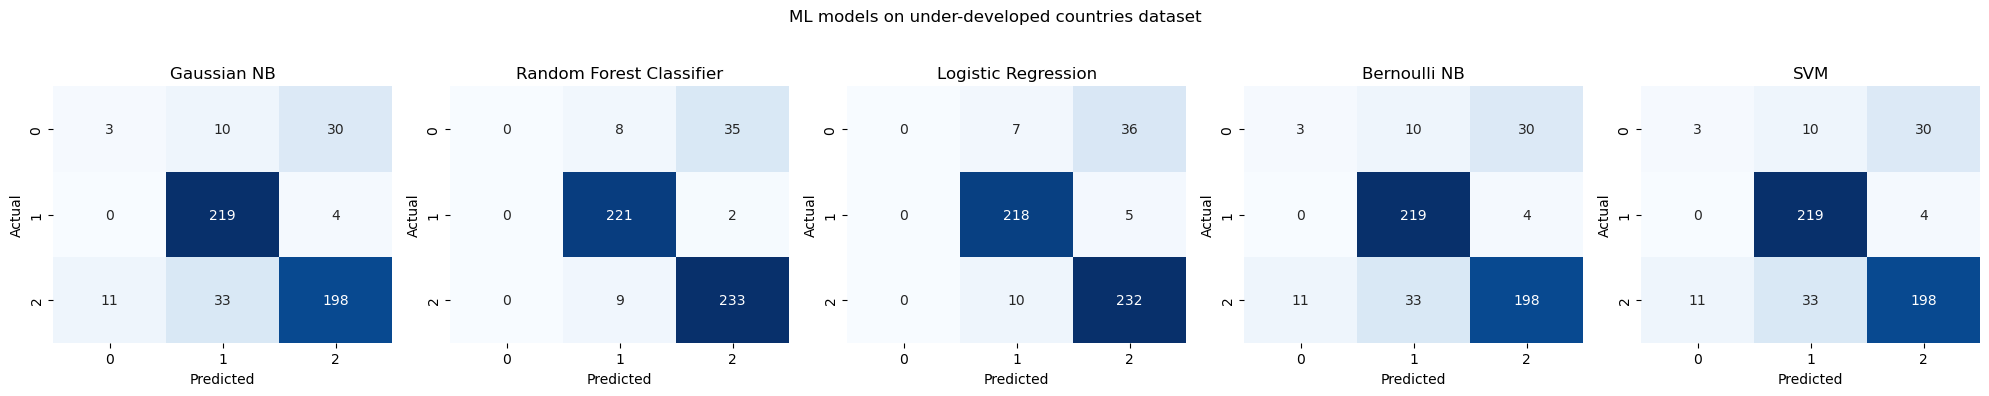

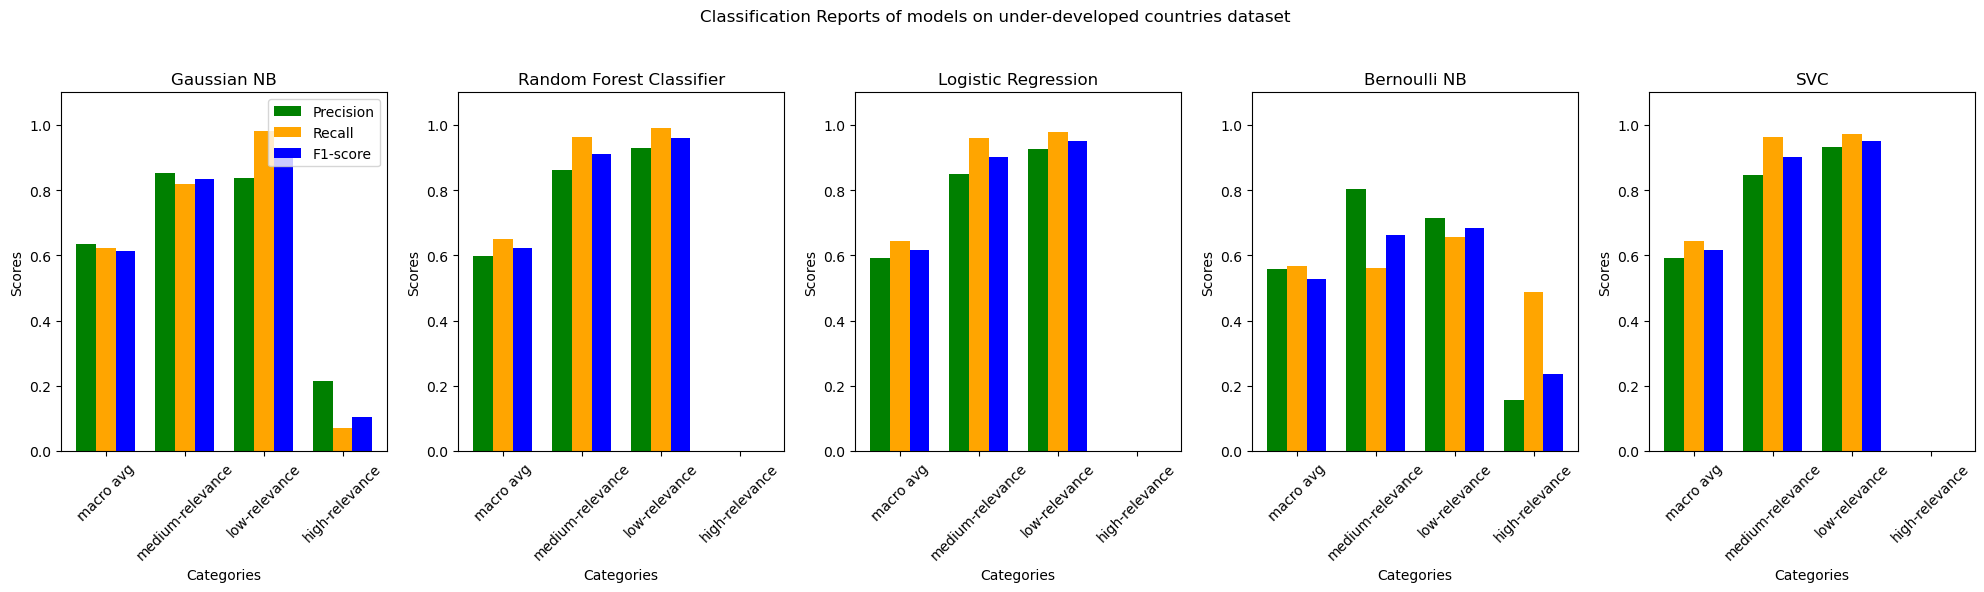

In [79]:
k = under.keys()
acc = [under[keys][0] for keys in k]
plt.bar(under.keys() , acc , color='black')
plt.xticks(rotation = 45 , size = 7)
plt.xlabel("Models")
plt.ylabel("accuracy score")
plt.title("models for under-developed dataset")
for i, value in enumerate(acc):
    plt.text(i, value, str(round(value,2)), ha='center', va='bottom')
cms = [under[keys][2] for keys in k]
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
fig.suptitle('ML models on under-developed countries dataset')

# Plot each confusion matrix
for i, (cm, ax) in enumerate(zip(cms, axes)):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)
    ax.set_title(list(developed.keys())[i])
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
categories = ['macro avg', 'medium-relevance','low-relevance','high-relevance']
bar_width = 0.25
crs = [under[keys][1] for keys in k]
# Create subplots
fig, axes = plt.subplots(1, 5, figsize=(20, 6))
fig.suptitle('Classification Reports of models on under-developed countries dataset')
# Plot each classification report
for i, (cr, ax) in enumerate(zip(crs, axes)):
    x = np.arange(len(categories))
    
    # Extracting precision, recall, and f1-score
    precision = [cr[cat]['precision'] for cat in categories]
    recall = [cr[cat]['recall'] for cat in categories]
    f1_score = [cr[cat]['f1-score'] for cat in categories]
    
    # Plot bars
    ax.bar(x - bar_width, precision, width=bar_width, color='green', label='Precision')
    ax.bar(x, recall, width=bar_width, color='orange', label='Recall')
    ax.bar(x + bar_width, f1_score, width=bar_width, color='blue', label='F1-score')
    
    # Formatting
    ax.set_title(models[i])
    ax.set_xticks(x)
    ax.set_xticklabels(categories, rotation=45)
    ax.set_ylim(0, 1.1)  # Ensure the y-axis is consistent
    ax.set_xlabel('Categories')
    ax.set_ylabel('Scores')
    if i == 0:  # Add legend only for the first subplot
        ax.legend(loc='upper right')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()